#  Rate vs. temperature
Author:

J. Angevaare // <j.angevaare@nikhef.nl> // 2020-06-11

As elucidated in the instrumentation paper (see ``0. before getting started`` for reference), we observed a temperature dependent rate. Here we show this correlation by loading data that was generated using ``03_stoomboot_data_access/5. Get Data`` in this folder

In [1]:
import socket
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numba
import uproot3
import os
import shutil
from matplotlib import rc
from scipy import optimize
# Set nice big fonts for plots
rc('font', size = 15)


In [2]:
try:
    import RP2023 as rp
except ModuleNotFoundError:
    # This module is not installed correctly, let's hack it in
    import sys
    import os
    path = os.path.join(os.path.abspath('.'), '..')
    sys.path.append(path) 
    import RP2023 as rp

## Get the data.
You first need to download the data in order to be able to continue. Since the files are large, we could not save it together with the other files in this github repository. You can download the files from:
https://surfdrive.surf.nl/files/index.php/s/6CBbzKGvCrttLkp and move it to the `../data/` directory. Thereafter you should be able to continue with the cells below. Make sure to extract the zip file you download via the link!

## Great lets open that data!

In [3]:
# Here we will loop over all datasets in the Ti44 folder! 
# We append each of the datasets seperately since that allows us to calculate the rate in that dataset
dsets = []
zip_files = '../data/temperature/ti44/'
for dset in os.listdir(zip_files):
    if 'zip' in dset:
        _path = os.path.join(zip_files, dset)
        d = pd.read_parquet(_path)
        dsets.append(d)
        del d

In [4]:
# Now we have a list of datasets. See for example the first one: 
dsets[0]

,channel,integral,time,temp
0,2,507.140594,3.670560e+09,28.5
1,3,354.686768,3.670560e+09,28.5
2,2,505.350769,3.670560e+09,28.5
3,3,461.941132,3.670560e+09,28.5
4,3,509.511261,3.670560e+09,28.5
...,...,...,...,...
1924710,3,496.046417,3.670561e+09,28.5
1924711,3,961.744019,3.670561e+09,28.5
1924712,2,487.761169,3.670561e+09,28.5
1924713,3,490.770233,3.670561e+09,28.5


## Calculate the efficiency for a given dataset. 

Below you insert how you want to calculate the efficiency. 

If you get stuck here, please ask questions!

The goal is to automatically calculate the efficiency for a given dataset. This you then add as a prpoerty to the dataframe that is being created inside ``parse_datasets``. 

In [5]:
def your_efficiency_function(data, normalization_factor = 1):
    """
    automatically calculate the effiency for a given dataset.
    """
    # You can add how you calculate the efficiency here for a given dataset. 
    # Plese note that both channels are in the 
    matched_data = rp.easy_coincidence_matching(data, source = 'Ti44', check_time_order = True)
    
    # Efficiency = ??
    
    # For now we will just return one for as a placeholder
    return 1 / normalization_factor

In [6]:
def parse_datasets(dsets):
    """
    Extract data from the datasets. 
    
    return: table containing the data of interest.
    """
    res = {'time':[],
           'temp':[],
           'dtemp':[],
           'counts':[],
           'dt':[],
           'efficiency':[]}

    for d in dsets:
        # CHANGE THIS. For now I will only show the 511 keV peak to calculate the rate for this energy.
        selected_data = rp.select_peak(d, 'integral', 511, 25)
        
        # This is a crude approximation as you have seen before. Can we do a better job?
        counts = len(selected_data)
        
        # For this dataset, just take the mean and standard deviation and save those values
        res['time'].append(np.mean(selected_data['time']))
        res['temp'].append(np.mean(selected_data['temp']))
        res['dtemp'].append(np.std(selected_data['temp']))
        
        # Save the counts. NB: this is the combined count for both channels!!!
        res['counts'].append(counts)
        
        # Calculate the duration of the dataset (needed to convert counts to a rate)
        res['dt'].append(selected_data['time'].max() - selected_data['time'].min())
        
        # Most importantly calculate the efficiency for the given dataset
        efficiency = your_efficiency_function(selected_data, normalization_factor = 1)
        res['efficiency'].append(efficiency)
    return pd.DataFrame(res)

In [7]:
res = parse_datasets(dsets)
# Our results are saved in the following dataframe:
res

Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May take a while
Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May take a while
Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May take a while
Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May take a while
Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May take a while
Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May

,time,temp,dtemp,counts,dt,efficiency
0,3.670560e+09,28.500000,0.000000e+00,684542,1836.196517,1.0
1,3.670820e+09,32.500000,0.000000e+00,677204,1819.315351,1.0
2,3.662180e+09,29.500000,0.000000e+00,675126,1806.004872,1.0
3,3.671538e+09,27.375143,4.321815e-02,687854,1843.661346,1.0
4,3.661271e+09,23.494801,2.220039e-02,684747,1826.877166,1.0
5,3.670995e+09,31.100000,4.618528e-14,680907,1826.881777,1.0
6,3.661678e+09,22.911990,3.248448e-02,687230,1830.551403,1.0
7,3.671165e+09,29.800000,7.105427e-15,683156,1830.939208,1.0
8,3.662468e+09,32.282838,3.770483e-02,672306,1798.412015,1.0
9,3.661158e+09,28.705805,2.338422e-02,676322,1806.450096,1.0


# Check temperature rate - temperature correlation
To illustrate the correlation I'll plot the rate vs temperature below. Can you make a similar plot for the efficiency?

In [8]:
def lin_function(x, a, b):
    return a * x + b 

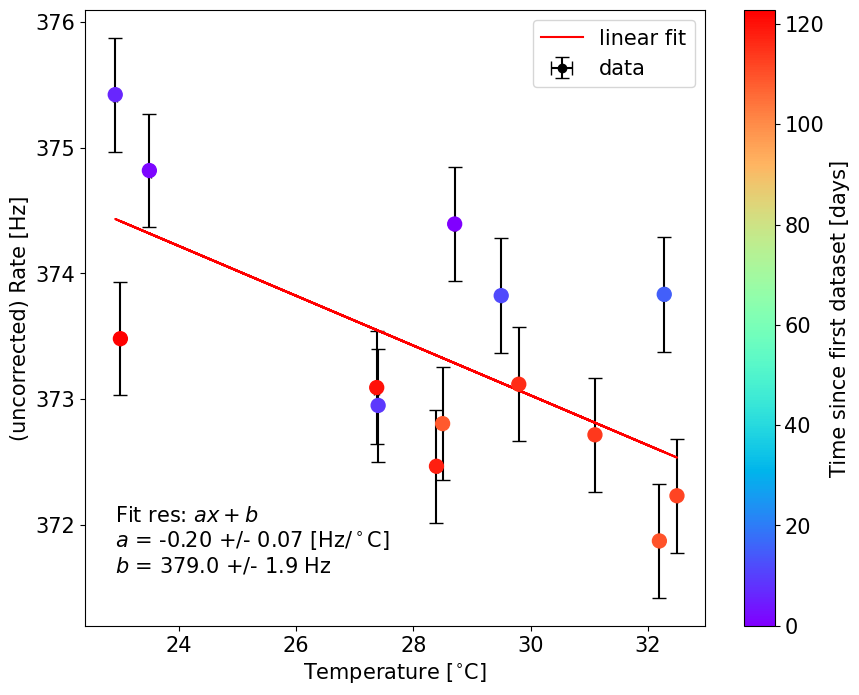

In [9]:
def plot_res():
    """
    Make a plot of the temperature versus rate (uncorrected for the normal exponential decay).
    """
    
    plt.figure(figsize = (10,8))
    # Select the values to plot
    temp = res['temp']
    dtemp = res['dtemp']
    rate = res['counts'] / res['dt']
    drate = np.sqrt(res['counts']) / res['dt']
    time = (res['time']-res['time'].values.min())/(3600*24)
    
    # Plot (plot first the uncertainties, then the points with the colorcoding indicating the time)
    plt.errorbar(temp, rate, xerr = dtemp, yerr = drate, c = 'k', marker = 'o',
                 label = 'data', linestyle = 'None', capsize = 5)

    cm = plt.get_cmap('rainbow')
    plt.scatter(temp, rate, c = time, cmap=cm,
                 zorder = 1000, s= 100, linestyle = 'None', marker = 'o')
    # plot the colorbar. Note this is in days since first dataset
    plt.colorbar(label = 'Time since first dataset [days]')
    
    # Add labels
    plt.xlabel('Temperature [$^{\circ}$C]')
    plt.ylabel('(uncorrected) Rate [Hz]')
    
    # Do a simple fit and show the best fit. This syntax may be confusing.
    # Please ask questions if you don't understand. 
    # The most important take away message is that this shows that the rate decreases 
    # for higher temperatures.
    fit_res = optimize.curve_fit(lin_function, temp, rate, sigma = drate)
    plt.plot(temp, lin_function(temp, *fit_res[0]), c = 'red', label = 'linear fit')
    print_res = ('Fit res: $a x + b$\n' +
                 '$a$ = %.2f +/- %.2f [Hz/${}^\circ$C]\n'%(fit_res[0][0], np.sqrt(fit_res[1][0][0])) +
                 '$b$ = %.1f +/- %.1f Hz'% (fit_res[0][1], np.sqrt(fit_res[1][1][1])))
    plt.text(np.min(temp), np.min(rate), print_res, verticalalignment = 'center')
    plt.legend()
plot_res()